# Utility Based Robustness Evaluation

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model_info import model_to_params, model_to_traindata, model_to_year, model_to_abrv
from copy import deepcopy
from itertools import combinations, product

## Data Loading and Annotation

First we will read the CSV using Pandas and add to it some meta data related to the models

In [19]:
#IMPORTANT: Change the file path to the location of the collated_results_all_models.csv file
df = pd.read_csv('results/collated_results_all_models-precomputed_data.csv')
df['model'] = df['model'].str.replace('rnnt', 'emformer-rnnt')
df['# Model Params'] = [model_to_params[model] for model in df['model']]
df['Training Data (hrs)'] = [model_to_traindata[model] for model in df['model']]
df['year'] = [model_to_year[model] for model in df['model']]
df['language'] = ['en' if df['dataset'][i] in ['librispeech_asr', 'LibriSpeech'] else 'es' for i in range(len(df))]
df['model (abrv)'] = [model_to_abrv[m] for m in df['model']]
df['WER'] = df['WER']*100
df['CER'] = df['CER']*100
df['augmentation'].replace({'None':None}, inplace=True)
df['runid'].fillna(0, inplace=True)
df['subset'].fillna(np.inf, inplace=True)
df = df[~(df['model'].isin(['emformer-rnnt', 'whisper-base.en']))]

We define the models considered in the English analysis. We shortlist a subset of the models for presentation in the paper, but you may modify the list as needed.

In [20]:
en_models = [
    'wav2vec2-large-960h-lv60-self',
    'hubert-large-ls960-ft',
    'wav2vec2-large-robust-ft-libri-960h',
    'wav2vec2-base-960h',
    'whisper-large-v2',
    'whisper-tiny.en',
    'deepspeech',
]
adv_augs = [
    'pgd',
    'universal_adv'
]
non_adv_augs = [aug for aug in df['augmentation'].unique().tolist() if aug not in adv_augs]
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [21]:
df = df[~(df['model'].isin(['whisper-large-v2', 'mms-1b-fl102']) & (df['augmentation'] == 'pgd') & (df['language'] == 'es') & (df['subset'] != 300))]
for model in df['model'].unique():
    for aug in df['augmentation'].unique():
        for sev in df['severity'].unique():
            for lang in df['language'].unique():
                subdf = df[(df['model'] == model) & (df['augmentation'] == aug) & (df['severity'] == sev) & (df['language'] == lang)]
                if len(subdf['runid'].unique()) == 1:
                    for i in subdf.index:
                        df.at[i, 'runid'] = 0


Separate out the results on the perturbed and unperturbed test sets.

In [22]:
# err_df = df[['model', 'model (abrv)', '# Model Params', 'Training Data (hrs)', 'year', 'augmentation', 'severity', 'WER', 'WED', 'nwords', 'CER', 'CED', 'nchars', 'language', 'runid']]
err_df = deepcopy(df)
err_df = err_df[(~err_df['augmentation'].isna()) & (err_df['augmentation'] != 'unoise')]
err_df = err_df[~(err_df['augmentation'].str.contains('+', regex=False)) & (err_df['severity'] > 0)]

In [23]:
for model in err_df['model'].unique():
    for dataset in err_df[err_df['model'] == model]['dataset'].unique():
        max_subset = err_df[(err_df['model'] == model) & (err_df['dataset'] == dataset)]['subset'].max()
        err_df = err_df[~((err_df['model'] == model) & (err_df['dataset'] == dataset) & (err_df['subset'] < max_subset))]
    
    # err_df = err_df[~((err_df['model'] == model) & (err_df['augmentation'] == 'pgd') & (err_df['subset'] < max_subset))]

In [24]:
clean_df = df[df['augmentation'].isna()]

## Metric Computation

### WER/CER Degradation (WERD/CERD)
Computing WER/CER degradation (WERD) i.e. the difference between the WER/CER on the perturbed and unperturbed test sets.

$WERD^M_\text{pert,sev}=WER^M_\text{pert,sev} - WER^M_{\text{clean}}$

In [25]:
wer_mces = []
cer_mces = []
for i in range(len(err_df)):
    row = err_df.iloc[i]
    # print(row.model, row.augmentation, row.severity)
    cwer = clean_df[clean_df['model'] == row['model']]['WER'].values[0]
    mce_wer = max(row['WER'] - cwer, 0)
    wer_mces.append(mce_wer)

    ccer = clean_df[clean_df['model'] == row['model']]['CER'].values[0]
    mce_cer = max(row['CER'] - ccer, 0)
    cer_mces.append(mce_cer)
err_df['WERD'] = wer_mces
err_df['CERD'] = cer_mces

## Normalized WER/CER (NWER/NCER)
Compute Normalized WER (NWER) and Normalized CER (NCER) i.e. the WER/CER on perturbed data normalized by the WER/CER of the baseline model.

$NWER^M_\text{pert,sev} = \frac{WER^M_\text{pert,sev}}{WER^{M_\text{base}}_\text{pert,sev}}$

**Note on Baseline models**: By default we use DeepSpeech and Whisper-Tiny as the baseline models for English and Spanish models. You may change the baseline models as needed by modifying the `en_base_model` and `es_base_model` variables.

In [26]:
wer_er_ces = []
cer_er_ces = []
wer_erd_ces = []
cer_erd_ces = []

en_base_model = 'deepspeech'
es_base_model = 'whisper-tiny'

en_base_model_df = err_df[err_df['model'] == en_base_model]
# es_base_model_df = err_df[err_df['model'] == 'wav2vec2-base-10k-voxpopuli-ft-es']
es_base_model_df = err_df[err_df['model'] == es_base_model]
lang2base = {
    'en': en_base_model_df,
    'es': es_base_model_df
}
for i in range(len(err_df)):
    row = err_df.iloc[i]
    base_model_df = lang2base[row['language']]
    idx = (base_model_df['augmentation'] == row['augmentation']) & (base_model_df['severity'] == row['severity']) & (base_model_df['runid'] == row['runid']) & (base_model_df['dataset'] == row['dataset'])
    base_model_row = base_model_df[idx]
    if base_model_row.empty:
        # print(row['model'], row['augmentation'], row['severity'], row['runid'])
        wer_er_ces.append(np.nan)
        cer_er_ces.append(np.nan)
        wer_erd_ces.append(np.nan)
        cer_erd_ces.append(np.nan)
        continue
    base_erd_wer = base_model_row['WERD'].values.mean()
    base_erd_cer = base_model_row['CERD'].values.mean()
    base_wer = base_model_row['WER'].values.mean()
    base_cer = base_model_row['CER'].values.mean()
    
    if (base_erd_cer == 0):
        base_erd_cer += 1e-4
    if (base_erd_wer == 0):
        base_erd_wer += 1e-4
    wer_erd_ce = row['WERD'] / (base_erd_wer)
    wer_erd_ces.append(wer_erd_ce)
    cer_erd_ce = row['CERD'] / (base_erd_cer)
    cer_erd_ces.append(cer_erd_ce)

    wer_er_ce = row['WER'] / (base_wer)
    wer_er_ces.append(wer_er_ce)
    cer_er_ce = row['CER'] / (base_cer)
    cer_er_ces.append(cer_er_ce)

err_df['NWER'] = wer_er_ces
err_df['NCER'] = cer_er_ces
err_df['NWERD'] = wer_erd_ces
err_df['NCERD'] = cer_erd_ces

In [27]:
values = ['CER', 'CERD', 'NCER', 'NCERD', 'WER', 'WERD', 'NWER', 'NWERD']
pt = pd.pivot_table(err_df[(err_df['language'] == 'en') & (err_df['model'].isin(en_models)) & (~err_df['augmentation'].isna())], values=values, index=['model (abrv)'])
pt = pt.reindex(values, axis=1)
pt = pt.sort_values(by='WER')
pt.style.format(decimal='.', thousands=',', precision=2)

,CER,CERD,NCER,NCERD,WER,WERD,NWER,NWERD
model (abrv),,,,,,,,
wsp-lg,8.27,6.44,0.35,0.95,12.41,7.71,0.22,0.20
hubt-lg,12.85,12.31,0.30,0.45,21.28,19.20,0.29,0.33
w2v2-lg-slf,14.38,13.89,0.31,0.41,22.28,20.46,0.29,0.32
w2v2-lg-rob,16.19,15.48,0.38,0.49,26.60,23.96,0.36,0.41
w2v2-bs,22.89,21.70,0.63,70.40,36.18,32.17,0.55,72.76
wsp-tn.en,33.12,30.49,0.82,106.90,45.98,39.54,0.65,22.80
ds,28.70,24.15,1.00,0.97,54.17,39.19,1.00,0.97


## Plotting the results
Below is the code used to generate the plots in the paper. You may modify the code as needed to generate the plots for your own analysis.

### Robustness Against Adversarial Perturbations

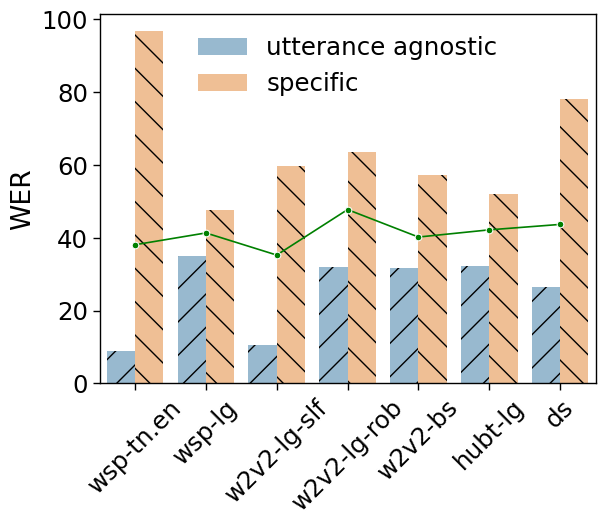

In [28]:
PGD_STR = 'specific'
UNIV_STR = 'utterance agnostic'
data = deepcopy(err_df[(err_df['severity'] > 0) & ((err_df['augmentation'].isin(['pgd', 'universal_adv']))) & (err_df['language'] == 'en') & (err_df['model'].isin(en_models))])
data = data.rename(columns={'augmentation': 'perturbation'})
data = data.sort_values(by=['model (abrv)', 'perturbation', 'severity'], ascending=[False, False, True])
data['perturbation'] = data['perturbation'].str.replace('universal_adv', UNIV_STR)
data['perturbation'] = data['perturbation'].str.replace('pgd', PGD_STR)
with sns.plotting_context('paper', font_scale=2.):
    ax_line = sns.lineplot(data=data, x='model (abrv)', y='WER', ci=None, marker='o', color='g', sort=False)
    ax = sns.barplot(data=data, x='model (abrv)', y='WER', hue='perturbation', ci=None, alpha=0.5)
    plt.xticks(rotation=45, ha='center')
    plt.xlabel('')
    plt.legend(frameon=False)
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)

### Robustness and Perturbation Severity

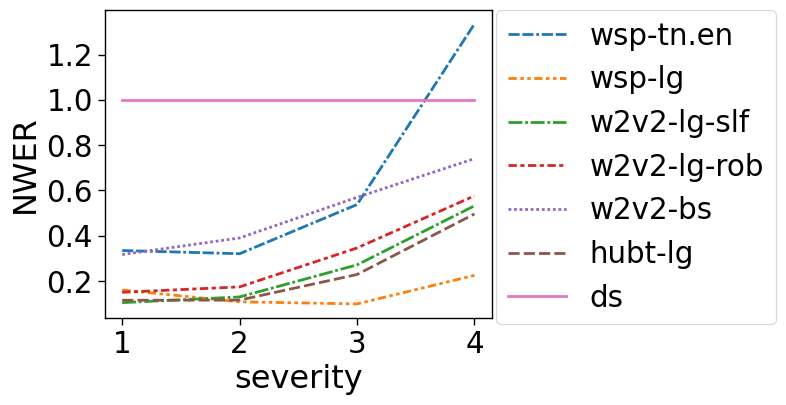

In [569]:
data = err_df[(err_df['severity'] > 0) & (~(err_df['augmentation'].isin(['unoise'] + adv_augs))) & (err_df['language'] == 'en') & (err_df['model'].isin(en_models))].sort_values(by='NWER')
data = data.pivot_table(index=['model (abrv)', 'runid', 'severity'], values='NWER', aggfunc='mean').reset_index()
plt.figure(figsize=(5,4))
# plt.subplot(1, 2, 1)
with sns.plotting_context('paper', font_scale=2.4, rc={'lines.linewidth': 2}):
    sns.lineplot(data=data, x='severity', y="NWER", hue='model (abrv)', style='model (abrv)', ci=False, hue_order=sorted(data['model (abrv)'].unique(), reverse=True))
    plt.xticks(range(1,5), range(1,5))
    # plt.subplot(1, 2, 2)
    # ax = sns.lineplot(data=data, x='severity', y="CWED", hue='model', style='model', ci=False, hue_order=sorted(data['model'].unique(),reverse=True))
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [59]:
pt = pd.pivot_table(err_df[(err_df['augmentation'] != 'unoise') & ~((err_df['augmentation'] == 'rir') & (err_df['severity'] == 0)) & (err_df['language'] == 'en') & (err_df['model'].isin(en_models))], values='CCED', columns='model', index=['augmentation', 'severity'])
print(pt.style.format(decimal='.', thousands='.', precision=2).to_latex())

\begin{tabular}{llrrrrrrr}
 & model & deepspeech & hubert-large-ls960-ft & wav2vec2-base-960h & wav2vec2-large-960h-lv60-self & wav2vec2-large-robust-ft-libri-960h & whisper-large-v2 & whisper-tiny.en \\
augmentation & severity &  &  &  &  &  &  &  \\
\multirow[c]{4}{*}{env_noise} & 1 & 1.00 & 0.12 & 0.50 & 0.12 & 0.15 & 0.00 & 0.16 \\
 & 2 & 1.00 & 0.20 & 0.70 & 0.19 & 0.22 & 0.01 & 0.23 \\
 & 3 & 1.00 & 0.30 & 0.86 & 0.31 & 0.34 & 0.10 & 0.49 \\
 & 4 & 1.00 & 0.74 & 1.03 & 0.85 & 0.76 & 0.58 & 1.25 \\
\multirow[c]{4}{*}{gnoise} & 1 & 1.00 & 0.03 & 1.43 & 0.09 & 0.09 & 0.00 & 0.23 \\
 & 2 & 1.00 & 0.08 & 1.52 & 0.33 & 0.26 & 0.05 & 0.27 \\
 & 3 & 1.00 & 0.26 & 1.46 & 0.69 & 0.52 & 0.12 & 0.48 \\
 & 4 & 1.00 & 1.20 & 1.39 & 1.40 & 1.33 & 0.84 & 3.14 \\
\multirow[c]{4}{*}{pgd} & 1 & 1.00 & 0.94 & 1.20 & 1.57 & 1.18 & 0.74 & 4.11 \\
 & 2 & 1.00 & 0.83 & 1.05 & 1.61 & 1.21 & 0.71 & 6.12 \\
 & 3 & 1.00 & 0.55 & 0.66 & 0.78 & 0.71 & 0.50 & 3.08 \\
 & 4 & 1.00 & 0.74 & 0.88 & 0.91 & 0.99 & 0

In [60]:
pt = pd.pivot_table(err_df[(err_df['augmentation'] != 'unoise') & (err_df['augmentation'] != 'voice_conversion') & ~((err_df['augmentation'] == 'rir') & (err_df['severity'] == 0)) & (err_df['language'] == 'es')], values='CCED', columns='model', index=['augmentation', 'severity'])
print(pt.style.format(decimal='.', thousands='.', precision=2).to_latex())

\begin{tabular}{llrrrrr}
 & model & mms-1b-fl102 & wav2vec2-base-10k-voxpopuli-ft-es & wav2vec2-large-xlsr-53-spanish & whisper-large-v2 & whisper-tiny \\
augmentation & severity &  &  &  &  &  \\
\multirow[c]{4}{*}{env_noise} & 1 & 0.19 & 1.01 & 0.36 & 8.16 & 1.00 \\
 & 2 & 0.18 & 0.66 & 0.32 & 2.70 & 1.00 \\
 & 3 & 0.17 & 0.44 & 0.28 & 1.18 & 1.00 \\
 & 4 & 0.23 & 0.27 & 0.25 & 0.43 & 1.00 \\
\multirow[c]{4}{*}{gnoise} & 1 & 0.17 & 0.83 & 0.37 & 0.12 & 1.00 \\
 & 2 & 0.18 & 0.63 & 0.43 & 0.10 & 1.00 \\
 & 3 & 0.17 & 0.45 & 0.43 & 0.11 & 1.00 \\
 & 4 & 0.24 & 0.29 & 0.32 & 0.30 & 1.00 \\
\multirow[c]{4}{*}{pitch_down} & 1 & 0.39 & 1.56 & 0.16 & 0.04 & 1.00 \\
 & 2 & 0.17 & 0.72 & 0.40 & 0.04 & 1.00 \\
 & 3 & 0.15 & 0.38 & 0.32 & 0.02 & 1.00 \\
 & 4 & 0.14 & 0.18 & 0.17 & 0.05 & 1.00 \\
\multirow[c]{4}{*}{pitch_up} & 1 & 0.23 & 2.36 & 0.24 & 0.02 & 1.00 \\
 & 2 & 0.16 & 1.81 & 0.32 & 0.01 & 1.00 \\
 & 3 & 0.36 & 1.02 & 0.52 & 0.01 & 1.00 \\
 & 4 & 0.33 & 0.40 & 0.35 & 0.01 & 1.00 \\
\m

### Robustness and Perturbation Types

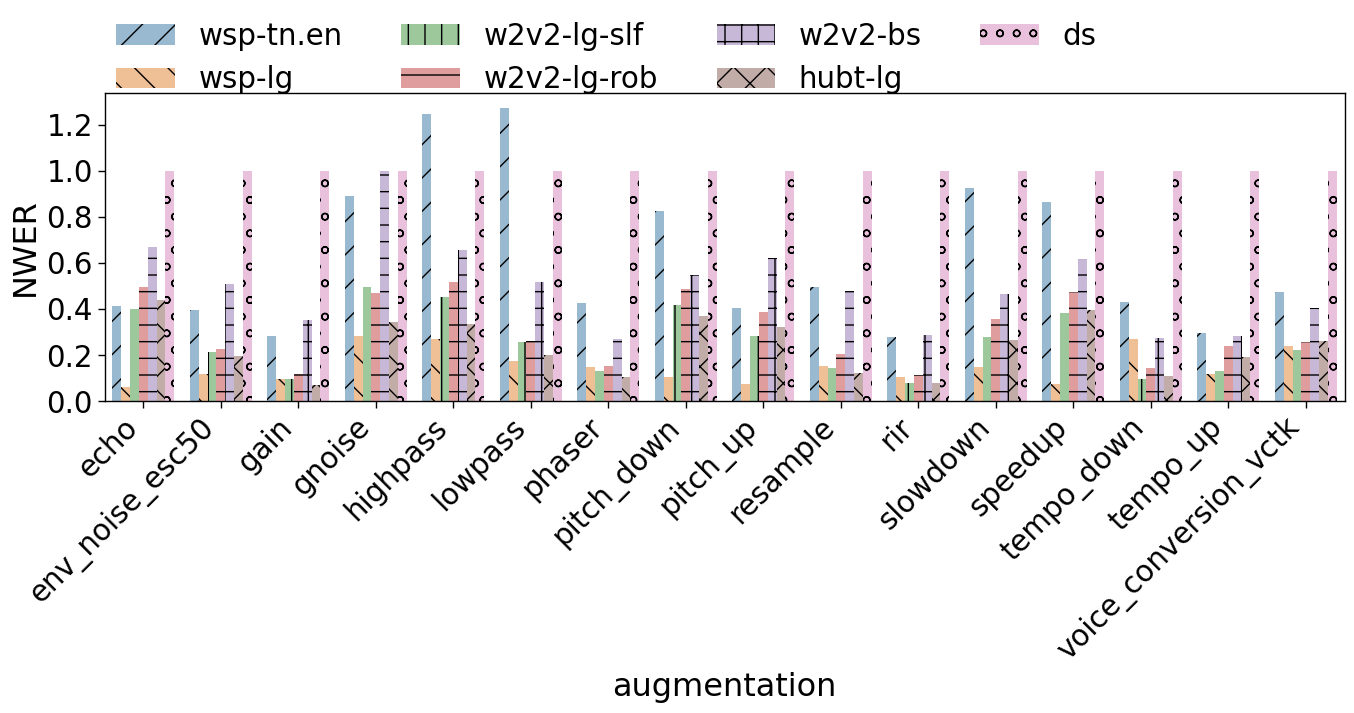

In [530]:
data = err_df[(err_df['augmentation'] != 'unoise') & (err_df['language'] == 'en') & (err_df['model'].isin(en_models)) & (~(err_df['augmentation'].isin(adv_augs)))].sort_values(by=['augmentation', 'NWER'])
data = data.pivot_table(index=['model (abrv)', 'augmentation', 'runid'], values='NWER', aggfunc='mean').reset_index()
plt.figure(figsize=(16,4))
# plt.subplot(1, 3, 1)
# sns.barplot(data=data, x='augmentation', y='CER', hue='model', ci=None)
# plt.xticks(rotation=45, ha='right')
# plt.legend([],[], frameon=False)
with sns.plotting_context('paper', font_scale=2.4, rc={'lines.linewidth': 2}):
    ax = sns.barplot(data=data, x='augmentation', y='NWER', hue='model (abrv)', hue_order=sorted(data['model (abrv)'].unique(),reverse=True), alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
    # create the legend again to show the new hatching
    plt.legend(bbox_to_anchor=(0.0, 1.27), loc=2, ncol=4, borderaxespad=0., frameon=False)
    # annotator = Annotator(ax, [('wsp-lg','hubt-lg'), ('hubt-lg', 'w2v2-lg-slf'), ('hubt-lg', 'w2v2-lg-rob'), ('w2v2-lg-slf', 'w2v2-lg-rob')], plot='barplot', data=data, x='augmentation', y='WER', hue='model (abrv)', hue_order=sorted(data['model (abrv)'].unique()))
    # annotator.configure(test='t-test_ind', text_format='star', loc='inside', hide_non_significant=True)
    # annotator.apply_and_annotate()

### Overall Robustness Results

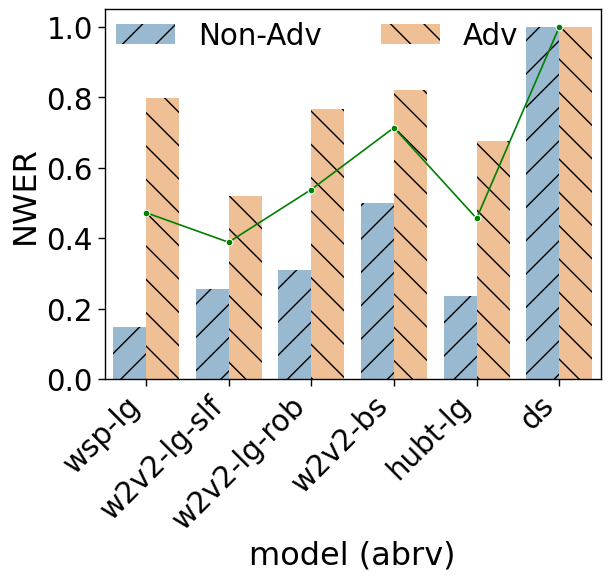

In [482]:
data = deepcopy(err_df[~(err_df['augmentation'].isin(['unoise'])) & (err_df['language'] == 'en') & (err_df['model'].isin(en_models))].sort_values(by=['augmentation', 'NWER']))
# data[(data['model (abrv)'] == 'ds') & (data['augmentation'].isin(adv_augs))]
data['augmentation'].replace({aug: 'Adv' for aug in adv_augs}, inplace=True)
data['augmentation'].replace({aug: 'Non-Adv' for aug in non_adv_augs}, inplace=True)
data = data.pivot_table(index=['model (abrv)', 'runid', 'augmentation'], values=['NWER', 'WER', 'NWERD'], aggfunc='mean').reset_index()
data = data.sort_values(by=['model (abrv)'], ascending=False)
with sns.plotting_context('paper', font_scale=2.4):
    # plt.subplot(1, 2, 1)
    model_order = sorted(data['model (abrv)'].unique(),reverse=True)
    ax_line = sns.lineplot(data=data, x='model (abrv)', y='NWER', ci=None, marker='o', color='g', sort=False)
    ax = sns.barplot(data=data, x='model (abrv)', y='NWER', hue='augmentation', hue_order=('Non-Adv', 'Adv'), alpha=0.5, ci=False)
    # ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge', rotation=45)
    # plt.legend(, frameon=False)
    plt.xticks(rotation=45, ha='right')
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
    plt.legend(bbox_to_anchor=(0., 1), loc=2, ncol=3, borderaxespad=0., frameon=False)

    # annotator = Annotator(ax, [('wsp-lg','hubt-lg'), ('hubt-lg', 'w2v2-lg-slf'), ('hubt-lg', 'w2v2-lg-rob'), ('w2v2-lg-slf', 'w2v2-lg-rob')], plot='barplot', data=data, x='model (abrv)', y='WER', order=data['model (abrv)'].unique())
    # annotator.configure(test='t-test_ind', text_format='star', loc='inside', hide_non_significant=False)
    # annotator.apply_and_annotate()

    # plt.subplot(1, 2, 2)
    # ax = sns.barplot(data=data, x='model (abrv)', y='WER', hue='model (abrv)', ci=None, hue_order=sorted(data['model (abrv)'].unique(),reverse=True), dodge=False)
    # plt.legend([],[], frameon=False)
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
# for bars, hatch in zip(ax.containers, hatches):
#         # Set a different hatch for each group of bars
#         for bar in bars:
#             bar.set_hatch(hatch)
#     # create the legend again to show the new hatching
# plt.legend(bbox_to_anchor=(0.05, 1.255), loc=2, ncol=4, borderaxespad=0.)

### Overall Robustness Results (Spanish)

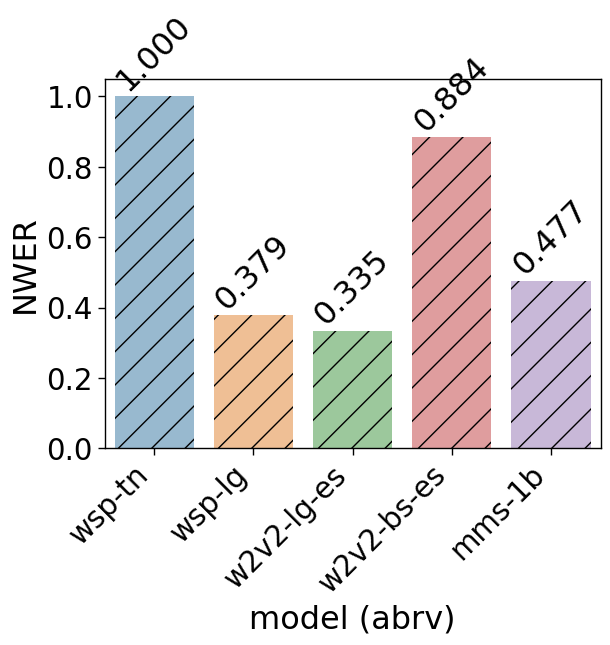

In [658]:
data = deepcopy(err_df[~(err_df['augmentation'].isin(['unoise'])) & (err_df['language'] == 'es')].sort_values(by=['augmentation', 'NWER']))
data['augmentation'].replace({aug: 'Adv' for aug in adv_augs}, inplace=True)
data['augmentation'].replace({aug: 'Non-Adv' for aug in non_adv_augs}, inplace=True)
data = data.pivot_table(index=['model (abrv)', 'augmentation', 'runid'], values=['NWER', 'WER'], aggfunc='mean').reset_index()
data = data.sort_values(by=['model (abrv)'], ascending=False)
with sns.plotting_context('paper', font_scale=2.4):
    # plt.subplot(1, 2, 1)
    model_order = sorted(data['model (abrv)'].unique(),reverse=True)
    ax = sns.barplot(data=data[data['augmentation'] == 'Non-Adv'], x='model (abrv)', y='NWER', alpha=0.5, ci=None)
    ax.bar_label(ax.containers[-1], fmt='%.3f', label_type='edge', rotation=45)
    # ax_line = sns.lineplot(data=data, x='model (abrv)', y='NWER', ci=None, marker='o', color='g', sort=False)
    # plt.legend([],[], frameon=False)
    plt.xticks(rotation=45, ha='right')
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)

### Robustness and Perturbation Types (Spanish)

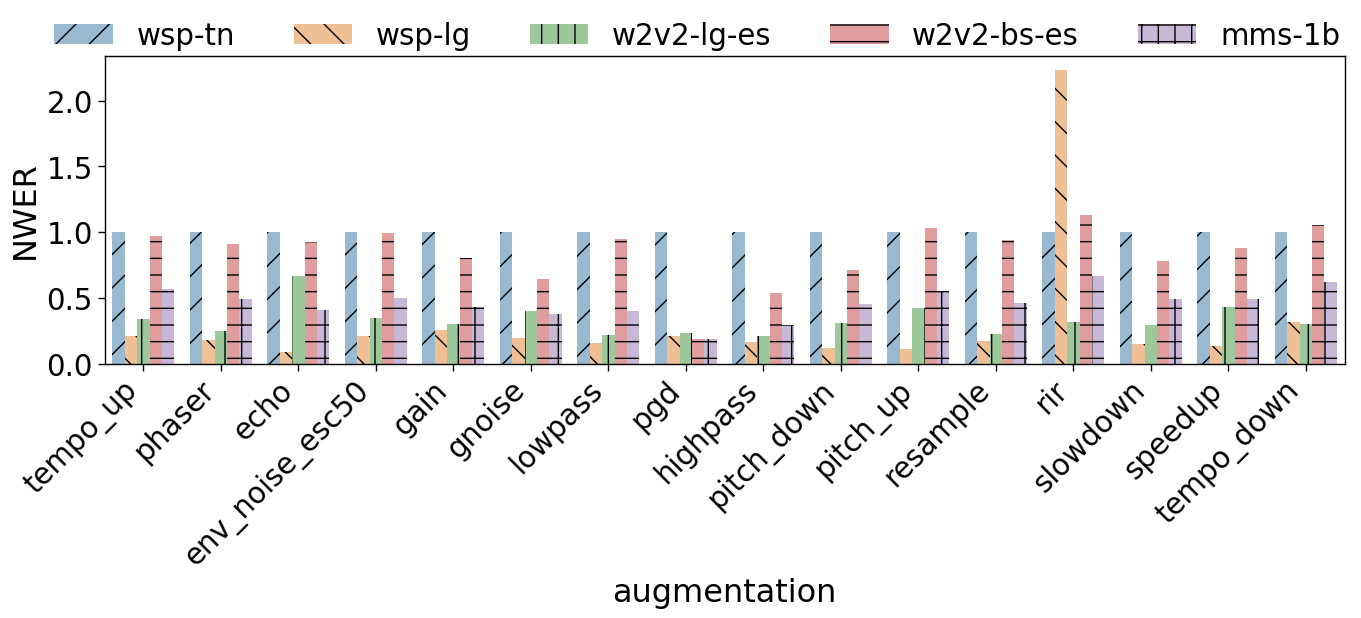

In [650]:
data = err_df[~(err_df['augmentation'].isin(['unoise', 'voice_conversion', 'env_noise'])) & (err_df['language'] == 'es')]
# data[data['model (abrv)'] == 'wsp-tn']
data = data.pivot_table(index=['model (abrv)', 'augmentation', 'runid'], values='NWER', aggfunc='mean').reset_index()
data = data.sort_values(by=['model (abrv)'], ascending=False)
plt.figure(figsize=(16,4))
# plt.subplot(1, 2, 1)
with sns.plotting_context('paper', font_scale=2.4, rc={'lines.linewidth': 2}):
    ax = sns.barplot(data=data, x='augmentation', y='NWER', hue='model (abrv)', alpha=0.5, ci=None)

    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)

    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(-0.05, 1.15), loc=2, ncol=5, borderaxespad=0., frameon=False)
# plt.legend([],[], frameon=False)
# plt.subplot(1, 2, 2)
# sns.barplot(data=data, x='augmentation', y='WER', hue='model', ci=None)
# plt.xticks(rotation=45, ha='right')

### Comparison of Whisper-large's Robustness Across Languages

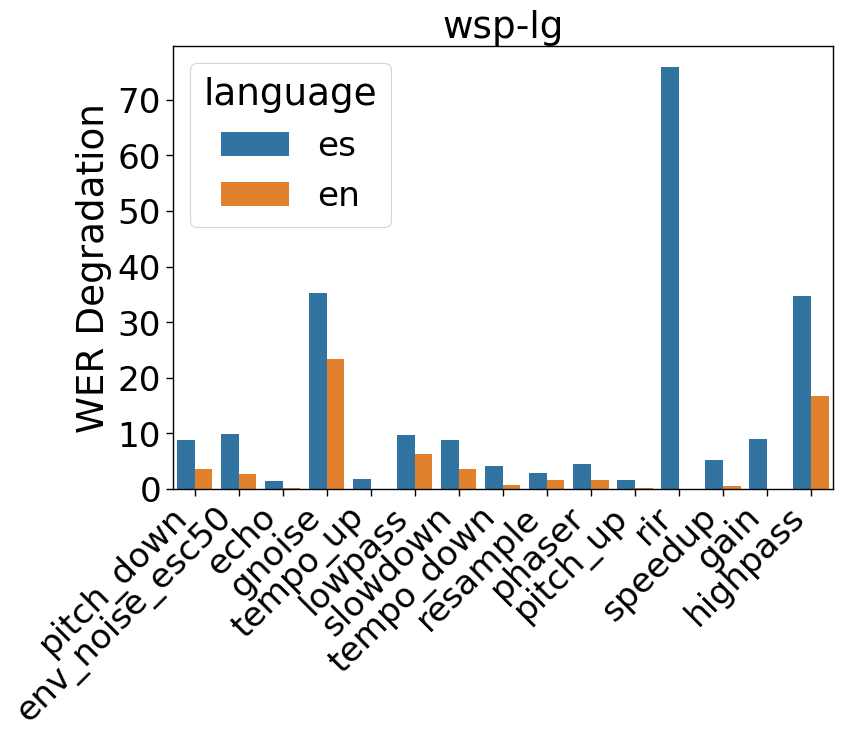

In [667]:
data = err_df[(~(err_df['augmentation'].str.startswith('voice_conversion'))) & ~(err_df['augmentation'].isin(['unoise', 'env_noise']+adv_augs))  & err_df['model'].isin(['whisper-large-v2'])]
data = deepcopy(data)
data.rename(columns={'WERD': 'WER Degradation'}, inplace=True)
# clean_wers = []
# for row in data.iterrows():
#     clean_wer = clean_df[(clean_df['model (abrv)'] == row[1]['model (abrv)']) & (clean_df['dataset'] == row[1]['dataset'])]['WER'].values[0]
#     clean_wers.append(clean_wer)
# data['clean WER'] = clean_wers
# data['WER Degradation'] = 100 * data['WER Degradation'].values / np.array(clean_wer)
with sns.plotting_context('paper', font_scale=2.8):
    # g = sns.catplot(data=data, x='augmentation', y='WER Degradation', hue='language', ci=None, col='model (abrv)', kind='bar', sharey=True, margin_titles=True)
    nmodels = len(data['model (abrv)'].unique())
    plt.figure(figsize=(9,8))
    for i, model in enumerate(data['model (abrv)'].unique()):
        plt.subplot(1,nmodels,i+1)
        plt.title(model)
        g = sns.barplot(data=data[data['model (abrv)'] == model], x='augmentation', y='WER Degradation', hue='language', ci=None)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('')
        if i > 0:
            plt.ylabel('')
            plt.legend([],[], frameon=False)
    plt.tight_layout()
    # plt.subplot(1,2,1)
    # g = sns.barplot(data=data, x='augmentation', y='WER Degradation', hue='language', ci=None, col='model (abrv)')
    # for axes in g.axes.flat:
    #     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #     g.set_xlabels('')
    # plt.tight_layout()

### Robustness and Model Size

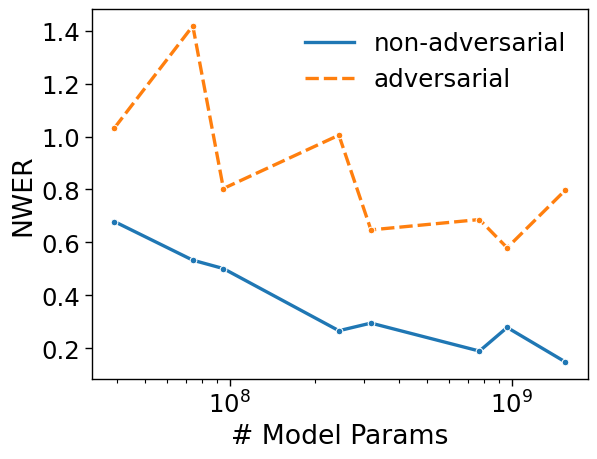

In [670]:
data = deepcopy(err_df[(err_df['augmentation'] != 'unoise') & (err_df['language'] == 'en') & (~(err_df['model'].isin(['deepspeech'])))])
data['Perturbation Type'] = ['adversarial' if isadv else 'non-adversarial' for isadv in data['augmentation'].isin(adv_augs)]
with sns.plotting_context('paper', font_scale=2., rc={'lines.linewidth': 2.4}):
    ax = sns.lineplot(data=data, x='# Model Params', y='NWER', hue='Perturbation Type', style='Perturbation Type', marker='o', ci=None)
    plt.legend(frameon=False)
    # ax = sns.lineplot(data=data, x='# Model Params', y='NWERD', style= 'Perturbation Type', marker='x')
    ax.set(xscale="log")
    # for x in data['# Model Params'].unique():
    #     model_name = data[data['# Model Params'] == x]['model (abrv)'].values[0]
    #     y = data[data['# Model Params'] == x]['NWER'].mean()
    #     ax.text(x, y, str(model_name), ha='center', va='bottom')

### Robustness and Training Data Size

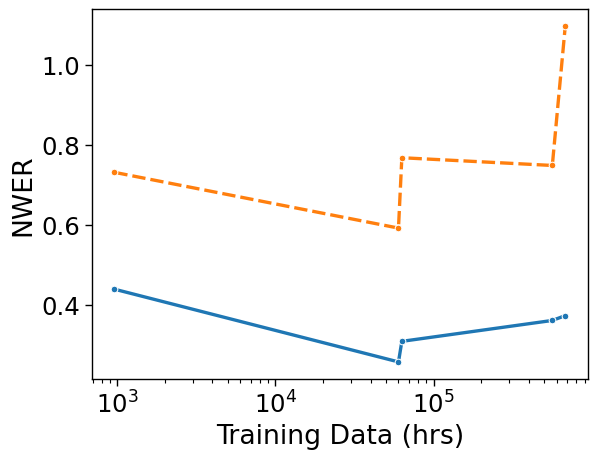

In [674]:
data = deepcopy(err_df[(err_df['augmentation'] != 'unoise') & (err_df['language'] == 'en') & (~(err_df['model'].isin(['deepspeech'])))])
data['Perturbation Type'] = ['adversarial' if isadv else 'non-adversarial' for isadv in data['augmentation'].isin(adv_augs)]
with sns.plotting_context('paper', font_scale=2., rc={'lines.linewidth': 2.4}):
    ax = sns.lineplot(data=data, x='Training Data (hrs)', y='NWER', hue='Perturbation Type', style='Perturbation Type', marker='o', ci=None, legend=False)
    # ax = sns.lineplot(data=data, x='# Model Params', y='NWERD', style= 'Perturbation Type', marker='x')
    ax.set(xscale="log")
    # for x in data['Training Data (hrs)'].unique():
    #     model_name = data[data['Training Data (hrs)'] == x]['model (abrv)'].values[0]
    #     y = data[data['Training Data (hrs)'] == x]['NWER'].mean()
    #     ax.text(x, y, str(model_name), ha='center', va='bottom')

### Robustness Within Model Families

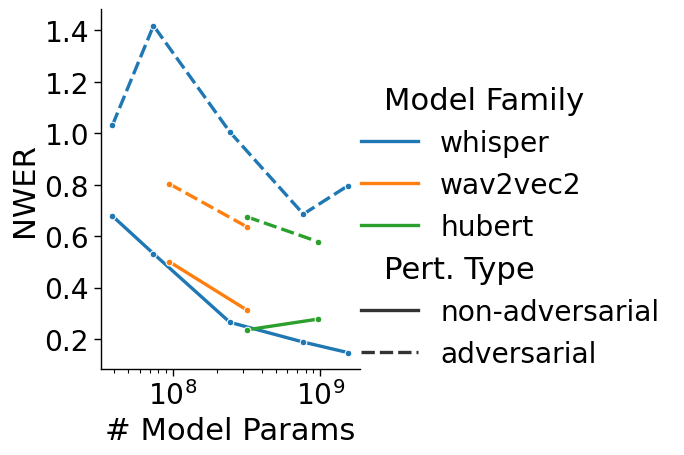

In [679]:
data = deepcopy(err_df[(err_df['augmentation'] != 'unoise') & (err_df['language'] == 'en') & (~(err_df['model'].isin(['deepspeech'])))])
data['Pert. Type'] = ['adversarial' if isadv else 'non-adversarial' for isadv in data['augmentation'].isin(adv_augs)]
data['Model Family'] = [model.split('-')[0] for model in data['model']]
data = data[data['Model Family'].isin(['wav2vec2', 'whisper', 'hubert'])]
with sns.plotting_context('paper', font_scale=2.3, rc={'lines.linewidth': 2.4}):
    ax = sns.relplot(data=data, x='# Model Params', y='NWER', hue='Model Family', marker='o', ci=None, style='Pert. Type', kind='line')
    # ax = sns.lineplot(data=data, x='# Model Params', y='NWERD', style= 'Perturbation Type', marker='x')
    ax.set(xscale="log")

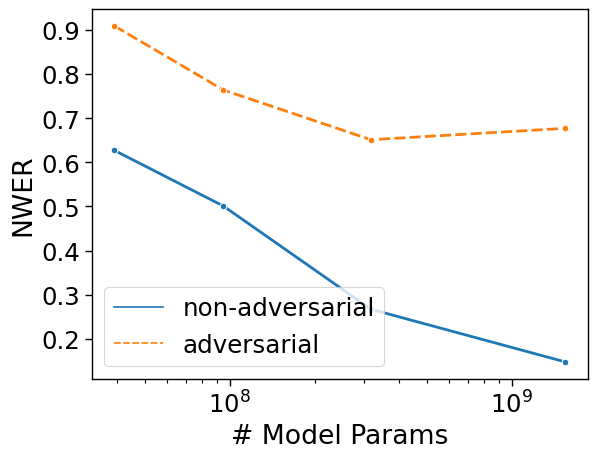

In [107]:
data = deepcopy(err_df[(err_df['augmentation'] != 'unoise') & (err_df['language'] == 'en') & (err_df['model'] != 'deepspeech') & (err_df['model'].isin(en_models))])
data['Perturbation Type'] = ['adversarial' if isadv else 'non-adversarial' for isadv in data['augmentation'].isin(adv_augs)]
# plt.figure(figsize=(10,4))
with sns.plotting_context('paper', font_scale=2):
    ax = sns.lineplot(data=data, x='# Model Params', y='NWER', marker='o', hue='Perturbation Type', style='Perturbation Type', linewidth=2, ci=None)
    ax.set(xscale="log")
    plt.legend(loc='lower left')
# for x in data['# Model Params'].unique():
#     model_name = data[data['# Model Params'] == x]['model'].values[0]
#     y = data[data['# Model Params'] == x]['NWER'].mean()
#     ax.text(x, y, str(model_name), ha='center', va='bottom')
# plt.xscale('log')
# plt.subplot(1, 2, 2)
# ax = sns.lineplot(data=data, x='# Model Params', y='CCED', marker='o')
# ax.set(xscale="log")
# plt.xscale('log')

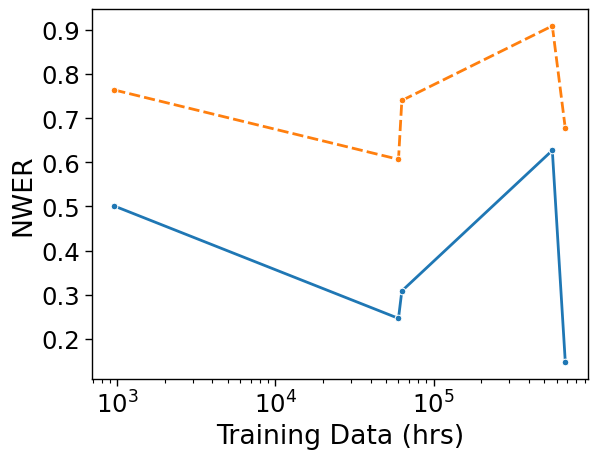

In [109]:
with sns.plotting_context('paper', font_scale=2):
    g = sns.lineplot(data=data, x='Training Data (hrs)', y='NWER', marker='o', hue='Perturbation Type', style='Perturbation Type', linewidth=2, ci=None, legend=False)
    plt.xscale('log')
# for x in data['Training Data (hrs)'].unique():
#     model_name = data[data['Training Data (hrs)'] == x]['model'].values[0]
#     y = data[data['Training Data (hrs)'] == x]['CCE'].mean()
#     g.text(x, y, str(model_name), ha='center', va='bottom')
# plt.subplot(1, 2, 2)
# g = sns.lineplot(data=data, x='Training Data (hrs)', y='CCED', marker='o')
# plt.xscale('log')

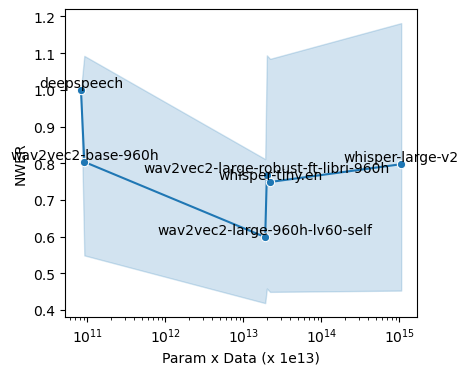

In [30]:
data['Param x Data (x 1e13)'] = data['# Model Params'] * data['Training Data (hrs)']
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
g = sns.lineplot(data=data, x='Param x Data (x 1e13)', y='NWER', marker='o')
plt.xscale('log')
for x in data['Param x Data (x 1e13)'].unique():
    model_name = data[data['Param x Data (x 1e13)'] == x]['model'].values[0]
    y = data[data['Param x Data (x 1e13)'] == x]['NWER'].mean()
    g.text(x, y, str(model_name), ha='center', va='bottom')
# xlabels = ['{:d}'.format(int(x)) for x in g.get_xticks()*1e-13]
# g.set_xticklabels(xlabels)
# plt.subplot(1, 2, 2)
# g = sns.lineplot(data=data, x='Param x Data (x 1e13)', y='CCED', marker='o')
# plt.xscale('log')
# xlabels = ['{:d}'.format(int(x))  for x in g.get_xticks()*1e-13]
# g.set_xticklabels(xlabels)